## Facial Filters

Using your trained facial keypoint detector, you can now do things like add filters to a person's face, automatically. In this optional notebook, you can play around with adding sunglasses to detected face's in an image by using the keypoints detected around a person's eyes. Checkout the `images/` directory to see what pther .png's have been provided for you to try, too!

<img src="images/face_filter_ex.png" width=60% height=60%/>

Let's start this process by looking at a sunglasses .png that we'll be working with!

In [1]:
# import necessary resources
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2

# Show plots inline (no interactive separate window)
%matplotlib inline

Image shape:  (1123, 3064, 4)


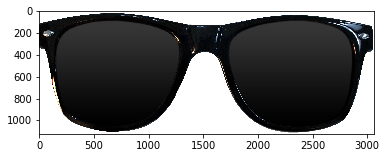

In [2]:
# load in sunglasses image with cv2 and IMREAD_UNCHANGED
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)

# plot our image
plt.imshow(sunglasses)

# print out its dimensions
print('Image shape: ', sunglasses.shape)

## The 4th dimension

You'll note that this image actually has *4 color channels*, not just 3 as your avg RGB image does. This is due to the flag we set `cv2.IMREAD_UNCHANGED`, which tells this to read in another color channel.

#### Alpha channel
It has the usual red, blue, and green channels any color image has, and the 4th channel respresents the **transparency level of each pixel** in the image; this is often called the **alpha** channel. Here's how the transparency channel works: the lower the value, the more transparent, or see-through, the pixel will become.  The lower bound (completely transparent) is zero here, so any pixels set to 0 will not be seen; these look like white background pixels in the image above, but they are actually totally transparent. 

This transparent channel allows us to place this rectangular image of sunglasses on an image of a face and still see the face area that is techically covered by the transparentbackground of the sunglasses image!

Let's check out the alpha channel of our sunglasses image in the next Python cell. Because many of the pixels in the background of the image have an alpha value of 0, we'll need to explicitly print out non-zero values if we want to see them.

The alpha channel looks like this (black pixels = transparent): 
[0 0 0 0]


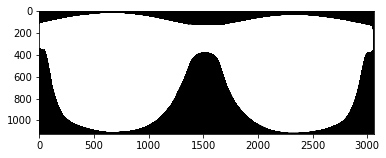

In [3]:
# print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]
print ('The alpha channel looks like this (black pixels = transparent): ')
plt.imshow(alpha_channel, cmap='gray')
print(sunglasses[0,0,:])

In [4]:
# just to double check that there are indeed non-zero values
# let's find and print out every value greater than zero
values = np.where(alpha_channel != 0)
print ('The non-zero values of the alpha channel are: ')
print (values)

The non-zero values of the alpha channel are: 
(array([  17,   17,   17, ..., 1109, 1109, 1109]), array([ 687,  688,  689, ..., 2376, 2377, 2378]))


#### Overlaying images

This means that when we place this sunglasses image on top of another image, we can use the transparency channel as a filter:

* If the pixels are non-transparent (alpha_channel > 0), overlay them on the new image

#### Keypoint locations

In doing this, it's helpful to understand which keypoint belongs to the eyes, mouth, etc., so in the image below we also print the index of each facial keypoint directly on the image so you can tell which keypoints are for the eyes, eyebrows, etc.,

<img src="images/landmarks_numbered.jpg" width=50% height=50%/>

It may be useful to use keypoints that correspond to the edges of the face to define the width of the sunglasses, and the locations of the eyes to define the placement.

Next, we'll load in an example image. Below, you've been given an image and set of keypoints from the provided training set of data, but you can use your own CNN model to generate keypoints for *any* image of a face (as in Notebook 3) and go through the same overlay process!

In [5]:
# load in training data
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


In [6]:
# helper function to display keypoints
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

Image name:  Christopher_Walken_01.jpg


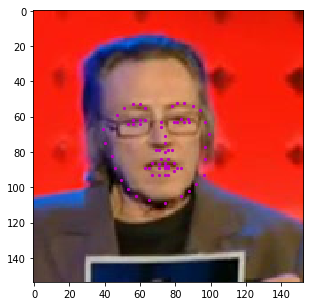

In [7]:
# a selected image
n = 120
image_name = key_pts_frame.iloc[n, 0]
image = mpimg.imread(os.path.join('data/training/', image_name))
# key_pts = key_pts_frame.iloc[n, 1:].as_matrix() # pandas 0.22.0
key_pts = key_pts_frame.iloc[n, 1:].values # pandas 1.0.1
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)

plt.figure(figsize=(5, 5))
show_keypoints(image, key_pts)
plt.show()

Next, you'll see an example of placing sunglasses on the person in the loaded image.

Note that the keypoints are numbered off-by-one in the numbered image above, and so `key_pts[0,:]` corresponds to the first point (1) in the labelled image.

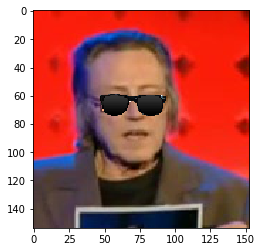

In [8]:
# Display sunglasses on top of the image in the appropriate place

# copy of the face image for overlay
image_copy = np.copy(image)

# top-left location for sunglasses to go
# 17 = edge of left eyebrow (keypoint #18)
x = int(key_pts[17, 0])
y = int(key_pts[17, 1])

# height and width of sunglasses
# h = length of nose (distance in y-direction between keypoint #28 and #35)
h = int(abs(key_pts[27,1] - key_pts[34,1]))
# w = left to right eyebrow edges (distance in x-direction between keypoint #18 and #27)
w = int(abs(key_pts[17,0] - key_pts[26,0]))

# read in sunglasses
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)
# resize sunglasses
new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

# get region of interest on the face to change
roi_color = image_copy[y:y+h,x:x+w]

# find all non-transparent pts
ind = np.argwhere(new_sunglasses[:,:,3] > 0)

# for each non-transparent point, replace the original image pixel with that of the new_sunglasses
for i in range(3):
    roi_color[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
# set the area of the image to the changed region with sunglasses
image_copy[y:y+h,x:x+w] = roi_color

# display the result!
plt.imshow(image_copy)

#### Further steps

Look in the `images/` directory to see other available .png's for overlay! Also, you may notice that the overlay of the sunglasses is not entirely perfect; you're encouraged to play around with the scale of the width and height of the glasses and investigate how to perform [image rotation](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html) in OpenCV so as to match an overlay with any facial pose.

Image name:  Kurt_Warner_11.jpg


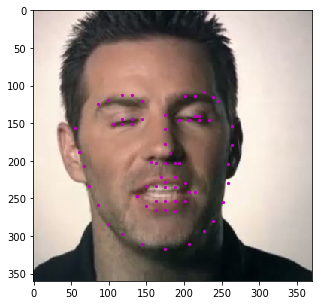

In [9]:
# a selected image
n = 1000
image_name = key_pts_frame.iloc[n, 0]
image = mpimg.imread(os.path.join('data/training/', image_name))
# key_pts = key_pts_frame.iloc[n, 1:].as_matrix() # pandas 0.22.0
key_pts = key_pts_frame.iloc[n, 1:].values # pandas 1.0.1
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)

plt.figure(figsize=(5, 5))
show_keypoints(image, key_pts)
plt.show()

#### Get rotation angle using a line through the eye keypoints

In [10]:
# Get width and height of the face

# top-left location for sunglasses to go
# 17 = edge of left eyebrow (keypoint #18)
x = int(key_pts[17, 0])
y = int(key_pts[17, 1])

# get required height and width of sunglasses using facial keypoints
# h = length of nose (distance in y-direction between keypoint #28 and #35)
h = int(abs(key_pts[27,1] - key_pts[34,1]))
# w = left to right eyebrow edges (distance in x-direction between keypoint #18 and #27)
w = int(abs(key_pts[17,0] - key_pts[26,0]))

In [11]:
# get left eye outer keypoints #37 and #40
outer_left_eye_key_pts = np.zeros((2,2))
outer_left_eye_key_pts[0, :] = key_pts[37,:] # get outer left keypoint of left eye
outer_left_eye_key_pts[1, :] = key_pts[40, :] # get outer right keypoint of left eye
print('Left eye outer keypoints: \n{}\n'.format(outer_left_eye_key_pts))

# get right eye outer keypoints #43 and #46
outer_right_eye_key_pts = np.zeros((2,2))
outer_right_eye_key_pts[0, :] = key_pts[43,:] # get outer left keypoint of right eye
outer_right_eye_key_pts[1, :] = key_pts[46, :] # get outer right keypoint of right eye
print('Right eye outer keypoints: \n{}\n'.format(outer_right_eye_key_pts))

Left eye outer keypoints: 
[[118. 145.]
 [131. 151.]]

Right eye outer keypoints: 
[[214. 140.]
 [220. 146.]]



In [12]:
# estimate rotation angle using the left and right eye facial keypoints
def estimate_rotation_angle(key_pts_left_eye, key_pts_right_eye):
    
    # Initialize auxiliary matrices for least square fitting
    A = np.ones((len(key_pts_left_eye) + len(key_pts_right_eye), 2))
    b = np.zeros((len(key_pts_left_eye) + len(key_pts_right_eye), 1))
    
    # Initialize auxiliary matrix row index
    row_idx = 0
    
    # Left eye keypoints:
    for idx in range(len(key_pts_left_eye)):
        # Set up auxiliary matrices for least square straigh line fit
        A[row_idx, 0] = key_pts_left_eye[idx, 0]
        b[row_idx] = key_pts_left_eye[idx, 1]
        # Increment row index
        row_idx += 1
    # Right eye keypoints:
    for idx in range(len(key_pts_right_eye)):
        # Set up auxiliary matrices for least square straigh line fit
        A[row_idx, 0] = key_pts_right_eye[idx, 0]
        b[row_idx] = key_pts_right_eye[idx, 1]
        # Increment row index
        row_idx += 1
    
    # Least square error straight line fit
    line_params = np.matmul(np.linalg.pinv(np.matmul(A.T, A)), np.matmul(A.T, b))
    
    # Print results
    print('\nEstimated straight line fit parameters using eye and eye brow keypoints:\n')
    print('Inclination: {}'.format(line_params[0]))
    print('Offset: {}\n'.format(line_params[1]))
    
    # Get rotation angle in degrees
    rotation_angle = 180.*np.arctan(line_params[0])/np.pi
    print('\nCalculate rotation angle of the estimated straight line through both eyes w.r.t horizontal axis:\n')
    print('Estimated rotation angle in [°]: {}°\n'.format(rotation_angle))

    # Return rotation angle
    return rotation_angle, line_params

In [13]:
# estimate facial rotation angle using least square straight line fine through both detected eyes
rotation_angle, line_params = estimate_rotation_angle(outer_left_eye_key_pts, outer_right_eye_key_pts)


Estimated straight line fit parameters using eye and eye brow keypoints:

Inclination: [-0.04683124]
Offset: [153.49643424]


Calculate rotation angle of the estimated straight line through both eyes w.r.t horizontal axis:

Estimated rotation angle in [°]: [-2.68127339]°



In [14]:
# helper function to display straight line fit
def show_line_fit(image, line_params):
    """Show image with straight line fit through eye keypoints"""
    height, width, channels = image.shape
    x = range(width)
    y = line_params[0] * x + line_params[1]
    plt.imshow(image)
    plt.plot(x, y, c='y', linewidth=3.0, linestyle='-.')

Image name:  Kurt_Warner_11.jpg


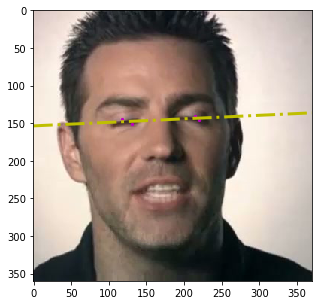

In [15]:
print('Image name: ', image_name)

plt.figure(figsize=(5, 5))
show_keypoints(image, outer_left_eye_key_pts)
show_keypoints(image, outer_right_eye_key_pts)
show_line_fit(image, line_params)
plt.show()

In [16]:
# rotate image without cropping the sides
def rotate_image(image, rotation_angle):
    """
    Rotate an image (angle in degrees) and expand it on all sides to avoid cropping
    - Assumes origin of the image to be in the upper left corner with x-axis pointing left and y-axis pointing down!
    """
    # Get width(number of columns) and height (number of rows) of the image
    h, w = image.shape[:2] # image shape has 3 dimensions (width, height and number of channels)
    
    # Get the center of the image with respect to the original image format
    image_center = (w/2, h/2) # getRotationMatrix2D needs coordinates in reverse order (w, h) compared to shape
    
    # Get the rotation matrix with respect to the original image format
    # Remarks:
    # - Takes rotation angle in degrees. Positive values mean counter-clockwise rotation 
    # - The coordinate origin is assumed to be the top-left corner with x-axis pointing right and y-axis pointing up!
    # - Adapt rotation angle provided here by fipping y- and z-coordinate axis (use negated rotation_angle)
    rotation_matrix = cv2.getRotationMatrix2D(image_center, -rotation_angle, 1.)

    # Cacluate the cosine and sine of the rotation, taking absolutes of those.
    abs_cos = abs(rotation_matrix[0,0]) 
    abs_sin = abs(rotation_matrix[0,1])

    # Find the new width and height bounds of the enlarged image
    bound_w = int(h * abs_sin + w * abs_cos)
    bound_h = int(h * abs_cos + w * abs_sin)

    # Subtract the old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_matrix[0, 2] += bound_w/2 - image_center[0]
    rotation_matrix[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_image = cv2.warpAffine(image, rotation_matrix, (bound_w, bound_h))
    
    # Return rotated image
    return rotated_image


Estimated straight line fit parameters using eye and eye brow keypoints:

Inclination: [-0.04683124]
Offset: [153.49643424]


Calculate rotation angle of the estimated straight line through both eyes w.r.t horizontal axis:

Estimated rotation angle in [°]: [-2.68127339]°



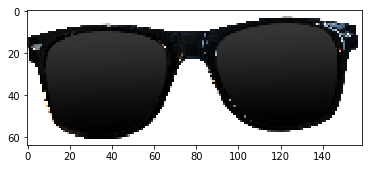

In [17]:
# Adapt the sunglasses image to the detected face pose by rotating and scaling the sunglasses

# read in sunglasses
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)

# Calculate required rotation angle using left and right eye keypoints
rotation_angle, line_params = estimate_rotation_angle(outer_left_eye_key_pts, outer_right_eye_key_pts)

# rotate sunglasses
rotated_sunglasses = rotate_image(sunglasses, rotation_angle)

# resize rotated sunglasses
new_sunglasses = cv2.resize(rotated_sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

# plot our rotated image
plt.imshow(new_sunglasses)

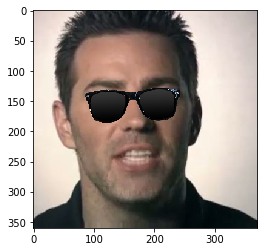

In [18]:
# Display sunglasses on top of the image in the appropriate place

# copy of the face image for overlay
image_copy = np.copy(image)

# get region of interest on the face to change
roi_color = image_copy[y:y+h,x:x+w]

# find all non-transparent pts
ind = np.argwhere(new_sunglasses[:,:,3] > 0)

# for each non-transparent point, replace the original image pixel with that of the new_sunglasses
for i in range(3):
    roi_color[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    

    # set the area of the image to the changed region with sunglasses
image_copy[y:y+h,x:x+w] = roi_color

# display the result!
plt.imshow(image_copy)

## Map sunglasses to predicted facial keypoints (quick and dirty test)

In [19]:
import torch

# Select net model no. to be imported
NET_MODEL_NO = 3
if NET_MODEL_NO == 0:
    from models_0 import Net
elif NET_MODEL_NO == 1:
    from models_1 import Net
elif NET_MODEL_NO == 2:
    from models_2 import Net
else:
    from models_3 import Net   # Recommendation: Use net model no. 3 => It seems to have the best performance

# initialize Net model structure
net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model

# set model directory
model_dir = 'saved_models/'

# set model name
if NET_MODEL_NO == 0:
    # model name for model 0 and minimum validation loss
    model_name_min_loss = 'keypoints_model_0_min_loss.pt'
    # model name for model 0 and last state after training
    model_name_last_state = 'keypoints_model_0_last_state.pt'
elif NET_MODEL_NO == 1:
    # model name for model 1 and minimum validation loss
    model_name_min_loss = 'keypoints_model_1_min_loss.pt'
    # model name for model 1 and last state after training
    model_name_last_state = 'keypoints_model_1_last_state.pt'
elif NET_MODEL_NO == 2:
    # model name for model 2 and minimum validation loss
    model_name_min_loss = 'keypoints_model_2_min_loss.pt'
    # model name for model 2 and last state after training
    model_name_last_state = 'keypoints_model_2_last_state.pt'
else:
    # model name for model 3 and minimum validation loss
    model_name_min_loss = 'keypoints_model_3_min_loss.pt'
    # model name for model 3 and last state after training
    model_name_last_state = 'keypoints_model_3_last_state.pt'

# Chose either the model with minimum validation loss or the model as of last state of trainging
MIN_LOSS = True

if MIN_LOSS:
    # set model path for minimum validation loss
    model_path = model_dir + model_name_min_loss
else:
    # set model path for last state after all training epochs
    model_path = model_dir + model_name_last_state

# load trained model parameters as state dictionary
net.load_state_dict(torch.load(model_path))

# print out your net and prepare it for testing (uncomment the line below)
net.eval() # set net model to evaluation mode => set dropout probability to zero and rescale weights

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop2): Dropout(p=0.15, inplace=False)
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop3): Dropout(p=0.2, inplace=False)
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop4): Dropout(p=0.25, inplace=False)
  (conv5): Sequential(
    (0): Conv2d(256, 512, kernel_size=

In [20]:
# detect regions of interest proposals with human faces in a given RGB color image
def detect_faces(image):
    '''
    Detects human faces in an RGB color image using openCV2's haar cascade classifier 
    and returns a list of bounding boxes for all detected faces in the image.
    input arguments:
        image: RGB color image
    output arguments:
        faces: a list of face detections with bounding boxes of format (upper left corner 
               (x, y), width w and heigh h)
    '''
    
    # load in a haar cascade classifier for detecting frontal faces
    face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
    
    # run the detector
    # the output here is an array of detections; the corners of each detection box
    # if necessary, modify these parameters until you successfully identify every face in a given image
    faces = face_cascade.detectMultiScale(image, 1.2, 2)
    
    # make a copy of the original image to plot detections on
    image_with_detections = image.copy()
    
    # loop over the detected faces, mark the image where each face is found
    for (x,y,w,h) in faces:
        # draw a rectangle around each detected face
        # you may also need to change the width of the rectangle drawn depending on image resolution
        cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3)
    
    fig = plt.figure(figsize=(9,9))
    
    plt.imshow(image_with_detections)
    
    # return image with face bounding box detections
    return image_with_detections, faces

In [21]:
# predict facial keypoints in an image within given region of interest proposals
def predict_facial_keypoints(image, image_with_detections, faces):
    '''
    Detects facial keypoints in a color image within given regions of interests 
    where faces are assumed due to face detections provided by another classifier
    (e. g. a haar cascade).
    input arguments:
        image: RGB color image
        image_with_detections: RGB color image with face bouding boxes added
        faces: list of face detections with bounding boxes of format (upper left 
        corner (x, y), width w and heigh h)
    global variables:
        net: facial keypoint detector model returning 68 facial keypoints
    output arguments:
        key_pts_for_all_faces: list of keypoint lists with 68 facial keypoints per
        list for all face detections given by faces 
    '''
    # make a copy of the sample image
    image_copy = np.copy(image)
    
    # set up the figure for visualization
    fig1 = plt.figure(figsize=(9,9))
    
    # plot image with detections from haar cascade
    ax1 = plt.imshow(image_with_detections)
    plt.title('Predicted facial keypoints within detected regions of interests')
    
    num_faces = len(faces)
    
    fig2 = plt.figure(figsize=(9,9))
    
    # initialize list of predicted facial keypoints for all faces
    key_pts_for_all_faces = []
    
    # loop over the detected faces from your haar cascade
    for idx, (x,y,w,h) in enumerate(faces):
        
        # Select the region of interest that is the face in the image 
        roi_rgb = image_copy[y:y+h, x:x+w]
        
        ## TODO: Convert the face region from RGB to grayscale
        roi_gray = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2GRAY)
        
        ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
        roi_gray = roi_gray / 255.0
        
        ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
        roi_gray = cv2.resize(roi_gray, (224, 224))
        
        ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
        roi_gray = np.expand_dims(roi_gray, axis=0) # add a color axis as first dim. according to torch format
        # roi_gray = np.expand_dims(roi_gray, axis=2) # expand numpy array dim. by a color axis as third dim.
        # roi_gray = roi_gray.transpose((2, 0, 1)) # transpose axis
        torch_roi_image = torch.from_numpy(roi_gray) #  convert numpy array to torch tensor
        torch_roi_image = torch_roi_image.unsqueeze(0) # add a tensor dimension for the batch size 
        torch_roi_image = torch_roi_image.type(torch.FloatTensor) # convert tensor to float64 format
        
        ## TODO: Make facial keypoint predictions using your loaded, trained network 
        ## perform a forward pass to get the predicted facial keypoints
        with torch.no_grad():
            
            # forward pass to get net output for the given region of interest
            predicted_roi_key_pts = net(torch_roi_image) # predict facial keypoints using net model
        
            # reshape to (batch_size = 1) x 68 x 2 pts
            predicted_roi_key_pts = predicted_roi_key_pts.view(predicted_roi_key_pts.size()[0], 68, -1)
            
            # remove "requires gradients" by detaching and convert to numpy and squeeze
            predicted_roi_key_pts = np.squeeze(predicted_roi_key_pts.detach().numpy())
            # predicted_roi_key_pts = predicted_roi_key_pts.detach()
    
        roi_image = torch_roi_image.numpy()[0] # convert tensor back to numpy array and reduce batch size dimension
        roi_image = np.transpose(roi_image, (1, 2, 0)) # transpose numpy array swapping color channel to the back
        
        # predicted_roi_key_pts = predicted_roi_key_pts[0].data
        # predicted_roi_key_pts = predicted_roi_key_pts.numpy()
        predicted_roi_key_pts = predicted_roi_key_pts * 50.0 + 100
                
        ## TODO: Display each detected face and the corresponding keypoints
        # change color or marker per detected face
        plt.figure(fig2.number) # activate figure 2
        ax = plt.subplot(1, num_faces, idx + 1)
        plt.imshow(np.squeeze(roi_image), cmap='gray')
        plt.scatter(predicted_roi_key_pts[:, 0], predicted_roi_key_pts[:, 1], s=20, marker='.', c='m')
        
        # rescale roi keypoints
        predicted_roi_key_pts = predicted_roi_key_pts * np.array([w / 224, h / 224])
        
        # get keypoints from roi keypoints
        predicted_key_pts = np.array([x, y]) + predicted_roi_key_pts
        
        # attach predicted keypoints for the current face to the list of keypoints for all faces
        key_pts_for_all_faces.append(predicted_key_pts)
        
        # add predicted facial key points to the image with face detections as bounding boxes
        plt.figure(fig1.number) # activate figure 1
        plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
        
    # show plot
    plt.show()
    
    # return list of facial keypoints for all detected faces
    return key_pts_for_all_faces

In [22]:
def show_face_with_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted and ground truth  keypoints (if provided)"""
    # define the figure size
    fig = plt.figure(figsize=(9,9))
    # show image
    plt.imshow(image)
    # plot predicted keypoints as magenta markers
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth keypoints as green markers
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='*', c='g')

Length of test data set: 770


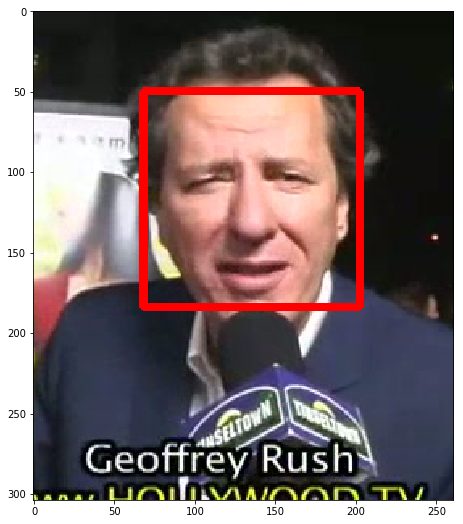

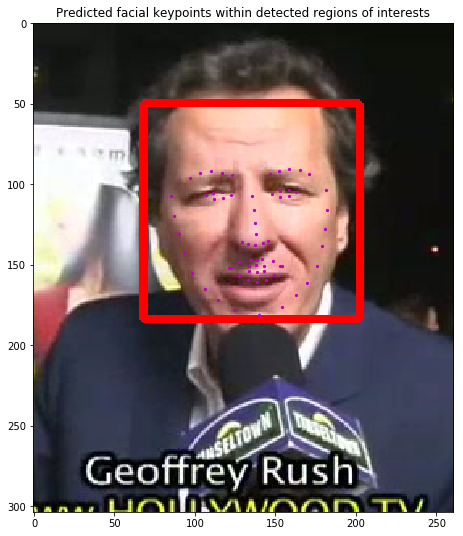

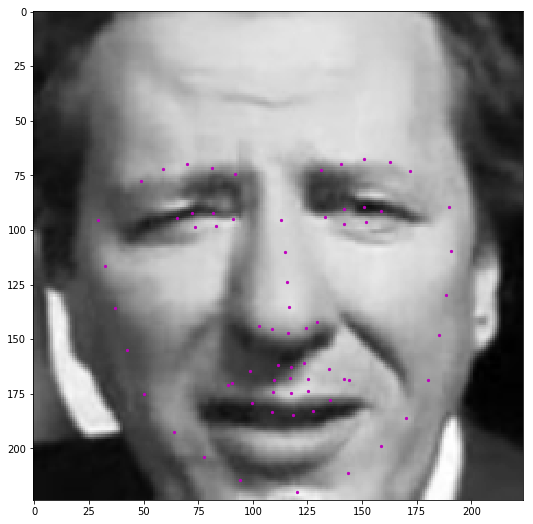

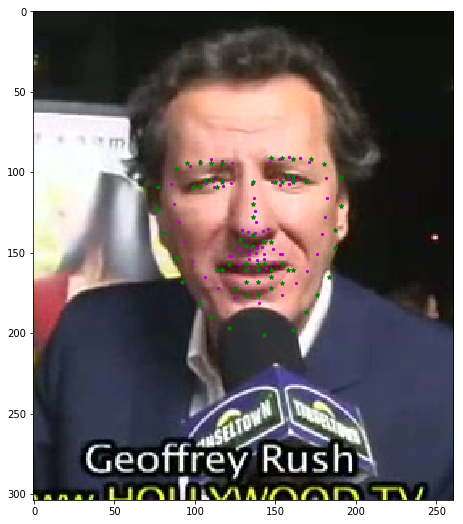

In [23]:
from data_load import FacialKeypointsDataset

#data_transform = transforms.Compose([])
data_transform = None

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

# print length of test dataset
print('Length of test data set: {}'.format(len(test_dataset)))

# randomly select a sample image from the current batch
random_idx = np.random.randint(0, len(test_dataset))
test_image = test_dataset[random_idx]['image']
gt_key_pts = test_dataset[random_idx]['keypoints']

# detect face bouding boxes in the given test image
test_image_with_detections, faces = detect_faces(test_image)

# predict facial keypoints in all proposed face bounding box detections
predicted_key_pts_for_all_faces = predict_facial_keypoints(test_image, 
                                                           test_image_with_detections, 
                                                           faces)

# plot predicted facial keypoints with ground truth keypoints in one image
show_face_with_all_keypoints(test_image,
                             predicted_key_pts=predicted_key_pts_for_all_faces[0],
                             gt_pts=gt_key_pts)

# take keypoints of the first detected face (in case there are more than one detected by the haar cascade classifier)
predicted_key_pts=predicted_key_pts_for_all_faces[0]

In [24]:
# Get width and height of the face

# top-left location for sunglasses to go
# 17 = edge of left eyebrow (keypoint #18)
x = int(predicted_key_pts[17, 0])
y = int(predicted_key_pts[17, 1])

# get required height and width of sunglasses using facial keypoints
# h = length of nose (distance in y-direction between keypoint #28 and #35)
h = int(abs(predicted_key_pts[27,1] - predicted_key_pts[34,1]))
# w = left to right eyebrow edges (distance in x-direction between keypoint #18 and #27)
w = int(abs(predicted_key_pts[17,0] - predicted_key_pts[26,0]))

In [25]:
# get left eye outer keypoints #37 and #40
outer_left_eye_key_pts = np.zeros((2,2))
outer_left_eye_key_pts[0, :] = predicted_key_pts[37,:] # get outer left keypoint of left eye
outer_left_eye_key_pts[1, :] = predicted_key_pts[40, :] # get outer right keypoint of left eye
print('Left eye outer keypoints: \n{}\n'.format(outer_left_eye_key_pts))

# get right eye outer keypoints #43 and #46
outer_right_eye_key_pts = np.zeros((2,2))
outer_right_eye_key_pts[0, :] = predicted_key_pts[43,:] # get outer left keypoint of right eye
outer_right_eye_key_pts[1, :] = predicted_key_pts[46, :] # get outer right keypoint of right eye
print('Right eye outer keypoints: \n{}\n'.format(outer_right_eye_key_pts))

Left eye outer keypoints: 
[[111.18060889 105.20771824]
 [117.70637131 108.605393  ]]

Right eye outer keypoints: 
[[152.72806794 103.92386144]
 [158.70969963 107.56828499]]




Estimated straight line fit parameters using eye and eye brow keypoints:

Inclination: [-0.01486846]
Offset: [108.33476361]


Calculate rotation angle of the estimated straight line through both eyes w.r.t horizontal axis:

Estimated rotation angle in [°]: [-0.85183722]°



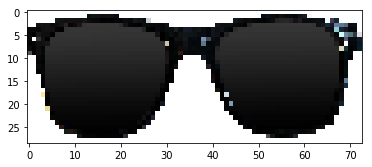

In [26]:
# Adapt the sunglasses image to the detected face pose by rotating and scaling the sunglasses

# read in sunglasses
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)

# Calculate required rotation angle using left and right eye keypoints
rotation_angle, line_params = estimate_rotation_angle(outer_left_eye_key_pts, outer_right_eye_key_pts)

# rotate sunglasses
rotated_sunglasses = rotate_image(sunglasses, rotation_angle)

# resize rotated sunglasses
new_sunglasses = cv2.resize(rotated_sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

# plot our rotated image
plt.imshow(new_sunglasses)

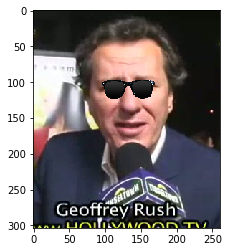

In [27]:
# Display sunglasses on top of the image in the appropriate place

# copy of the face image for overlay
test_image_copy = np.copy(test_image)

# get region of interest on the face to change
roi_color = test_image_copy[y:y+h,x:x+w]

# find all non-transparent pts
ind = np.argwhere(new_sunglasses[:,:,3] > 0)

# for each non-transparent point, replace the original image pixel with that of the new_sunglasses
for i in range(3):
    roi_color[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    

# set the area of the image to the changed region with sunglasses
test_image_copy[y:y+h,x:x+w] = roi_color

# display the result!
plt.imshow(test_image_copy)